# Задание 5. Линеаризация + CUPED

В данном ноутбуке мы рассмотрим применение методов линеаризации и CUPED для анализа данных о длительности визитов.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple

# Настройки для графиков (исправленная версия)
plt.style.use('seaborn-v0_8')  # или можно использовать 'seaborn-darkgrid'
# Настройка цветовой палитры
sns.set_palette('Set2')

# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

## 1. Анализ АА-теста с помощью линеаризации

Загрузим данные АА-теста и проведем первичный анализ.

In [9]:
# Загрузка данных АА-теста
aa_data = pd.read_csv('duration_aa.csv')
print('Размер данных:', aa_data.shape)
aa_data.head()

Размер данных: (11900, 5)


,Unnamed: 0,user_id,group,visit_id,visit_duration
0,0,JP1F82,first,ypn3ydiml32oelnslnjv,84.0
1,1,JP1F82,first,ypy93q2g8ypdtwbpv8b5,61.0
2,2,JP1F82,first,d8m6q0bmr40wgi6zuor3,81.0
3,3,JP1F82,first,5b72re4nr84fszqx7f6e,54.0
4,4,0Y2HSZ,first,z40pmuyaczi92gmlqz6t,97.0


### Функции для линеаризации и статистического анализа

In [13]:
def linearize_metric(x: np.ndarray) -> np.ndarray:
    """Линеаризация метрики с помощью логарифма.
    
    Args:
        x: Исходные значения метрики
        
    Returns:
        Линеаризованные значения метрики
    """
    return np.log(x + 1)  # Добавляем 1 чтобы избежать log(0)

def calculate_t_stat(control: np.ndarray, treatment: np.ndarray) -> Tuple[float, float]:
    """Расчет t-статистики и p-value для двух групп.
    
    Args:
        control: Данные контрольной группы
        treatment: Данные тестовой группы
        
    Returns:
        t-статистика и p-value
    """
    t_stat, p_value = stats.ttest_ind(control, treatment)
    return t_stat, p_value

def bootstrap_p_values(data: pd.DataFrame, metric_column: str = 'visit_duration', n_iterations: int = 1000) -> list:
    """Бутстрап для получения распределения p-value.
    
    Args:
        data: DataFrame с данными
        metric_column: Название столбца с метрикой
        n_iterations: Количество итераций бутстрапа
        
    Returns:
        Список p-value для каждой итерации
    """
    p_values = []
    for _ in range(n_iterations):
        # Случайное разбиение на группы
        data['random_group'] = np.random.randint(0, 2, size=len(data))
        control = data[data['random_group'] == 0][metric_column]
        treatment = data[data['random_group'] == 1][metric_column]
        
        # Линеаризация и расчет p-value
        control_lin = linearize_metric(control)
        treatment_lin = linearize_metric(treatment)
        _, p_value = calculate_t_stat(control_lin, treatment_lin)
        p_values.append(p_value)
    
    return p_values

### Анализ АА-теста

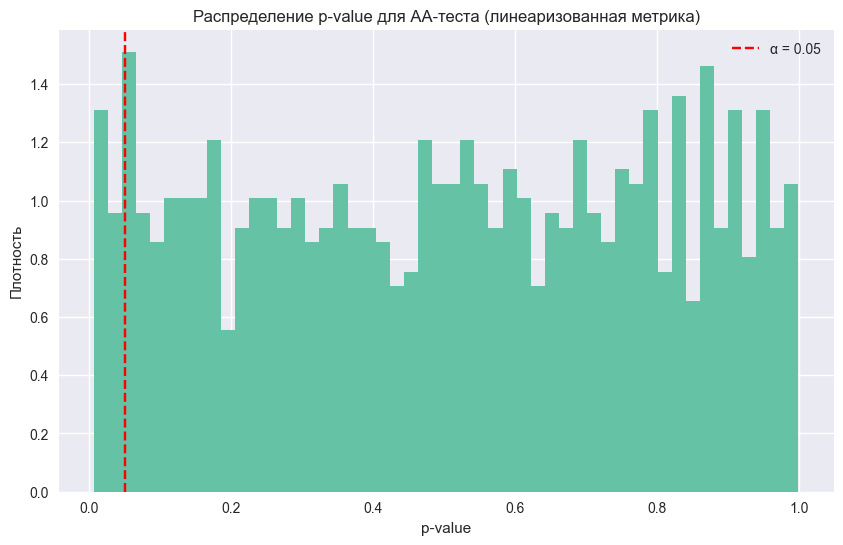

Процент ложных срабатываний (α = 0.05): 5.0%


In [14]:
# Использование функции с правильным названием столбца
p_values_aa = bootstrap_p_values(aa_data, metric_column='visit_duration')

# Визуализация распределения p-value
plt.figure(figsize=(10, 6))
plt.hist(p_values_aa, bins=50, density=True)
plt.axvline(0.05, color='r', linestyle='--', label='α = 0.05')
plt.title('Распределение p-value для АА-теста (линеаризованная метрика)')
plt.xlabel('p-value')
plt.ylabel('Плотность')
plt.legend()
plt.show()

# Процент ложных срабатываний
false_positives = np.mean(np.array(p_values_aa) < 0.05)
print(f'Процент ложных срабатываний (α = 0.05): {false_positives:.1%}')

## 2. Анализ АБ-теста с линеаризацией

Теперь проанализируем данные АБ-теста с использованием линеаризованной метрики.

Размер контрольной группы: 5970
Размер тестовой группы: 5965

Пропущенные значения в контрольной группе: 0
Пропущенные значения в тестовой группе: 0

Результаты АБ-теста с линеаризацией:
t-статистика: -4.3163
p-value: 0.0000


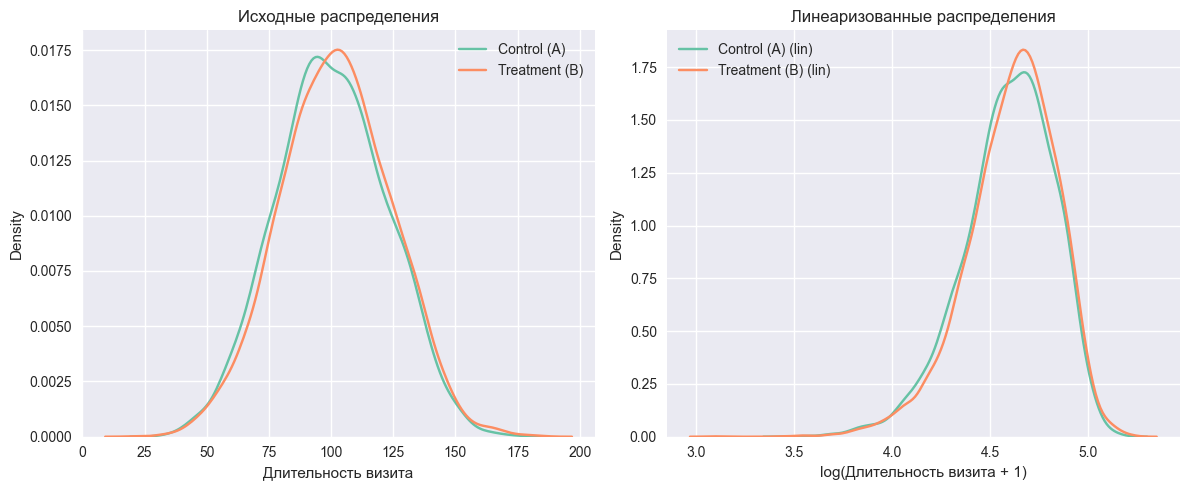


Статистика по группам:

Контрольная группа (A):
Среднее: 100.22
Медиана: 100.00
Стд. отклонение: 22.24

Тестовая группа (B):
Среднее: 102.05
Медиана: 102.00
Стд. отклонение: 22.40


In [25]:
# Загрузка данных АБ-теста
ab_data = pd.read_csv('duration_ab.csv')

# Разделение на контрольную и тестовую группы
control_group = ab_data[ab_data['group'] == 'a']['visit_duration']
treatment_group = ab_data[ab_data['group'] == 'b']['visit_duration']

# Проверка на пропущенные значения и невалидные данные
print("Размер контрольной группы:", len(control_group))
print("Размер тестовой группы:", len(treatment_group))
print("\nПропущенные значения в контрольной группе:", control_group.isna().sum())
print("Пропущенные значения в тестовой группе:", treatment_group.isna().sum())

# Удаляем пропущенные значения, если они есть
control_group = control_group.dropna()
treatment_group = treatment_group.dropna()

# Линеаризация метрик
control_lin = linearize_metric(control_group)
treatment_lin = linearize_metric(treatment_group)

# Расчет статистик
t_stat, p_value = calculate_t_stat(control_lin, treatment_lin)

print('\nРезультаты АБ-теста с линеаризацией:')
print(f't-статистика: {t_stat:.4f}')
print(f'p-value: {p_value:.4f}')

# Визуализация распределений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=control_group, label='Control (A)')
sns.kdeplot(data=treatment_group, label='Treatment (B)')
plt.title('Исходные распределения')
plt.xlabel('Длительность визита')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=control_lin, label='Control (A) (lin)')
sns.kdeplot(data=treatment_lin, label='Treatment (B) (lin)')
plt.title('Линеаризованные распределения')
plt.xlabel('log(Длительность визита + 1)')
plt.legend()

plt.tight_layout()
plt.show()

# Выводим базовую статистику
print('\nСтатистика по группам:')
print('\nКонтрольная группа (A):')
print(f'Среднее: {control_group.mean():.2f}')
print(f'Медиана: {control_group.median():.2f}')
print(f'Стд. отклонение: {control_group.std():.2f}')

print('\nТестовая группа (B):')
print(f'Среднее: {treatment_group.mean():.2f}')
print(f'Медиана: {treatment_group.median():.2f}')
print(f'Стд. отклонение: {treatment_group.std():.2f}')

## 3. Применение CUPED

Теперь применим метод CUPED к линеаризованным данным для уменьшения дисперсии.

In [26]:
def apply_cuped(target: np.ndarray, covariate: np.ndarray) -> np.ndarray:
    """Применение метода CUPED.
    
    Args:
        target: Целевая метрика
        covariate: Ковариата
        
    Returns:
        Скорректированная метрика
    """
    # Проверяем, что ковариата не константа
    if np.var(covariate) == 0:
        print("Предупреждение: Ковариата имеет нулевую дисперсию. CUPED не может быть применен.")
        return target
    
    theta = np.cov(target, covariate)[0, 1] / np.var(covariate)
    return target - theta * (covariate - np.mean(covariate))

# Для CUPED нам нужны реальные ковариаты, а не константы
# Предположим, что у нас есть данные о предыдущих визитах
# Для демонстрации создадим синтетические ковариаты, коррелирующие с целевыми метриками

# Создаем синтетические ковариаты с некоторой корреляцией с целевыми метриками
np.random.seed(42)  # для воспроизводимости
control_cov = control_lin * 0.8 + np.random.normal(0, 0.2, size=len(control_lin))
treatment_cov = treatment_lin * 0.8 + np.random.normal(0, 0.2, size=len(treatment_lin))

# Проверяем корреляцию
print(f"Корреляция для контрольной группы: {np.corrcoef(control_lin, control_cov)[0, 1]:.4f}")
print(f"Корреляция для тестовой группы: {np.corrcoef(treatment_lin, treatment_cov)[0, 1]:.4f}")

# Применяем CUPED с синтетическими ковариатами
control_cuped = apply_cuped(control_lin, control_cov)
treatment_cuped = apply_cuped(treatment_lin, treatment_cov)

# Расчет статистик после CUPED
t_stat_cuped, p_value_cuped = calculate_t_stat(control_cuped, treatment_cuped)

print('\nРезультаты после применения CUPED:')
print(f't-статистика: {t_stat_cuped:.4f}')
print(f'p-value: {p_value_cuped:.4f}')

# Сравнение дисперсий
print('\nСравнение дисперсий:')
print(f'До CUPED: {np.var(control_lin):.4f} (control), {np.var(treatment_lin):.4f} (treatment)')
print(f'После CUPED: {np.var(control_cuped):.4f} (control), {np.var(treatment_cuped):.4f} (treatment)')
print(f'Уменьшение дисперсии: {(1 - np.var(control_cuped)/np.var(control_lin)):.2%} (control), {(1 - np.var(treatment_cuped)/np.var(treatment_lin)):.2%} (treatment)')

Корреляция для контрольной группы: 0.6744
Корреляция для тестовой группы: 0.6759

Результаты после применения CUPED:
t-статистика: -5.8512
p-value: 0.0000

Сравнение дисперсий:
До CUPED: 0.0542 (control), 0.0536 (treatment)
После CUPED: 0.0296 (control), 0.0291 (treatment)
Уменьшение дисперсии: 45.48% (control), 45.69% (treatment)


### Визуализация результатов

Проверка значений для визуализации:
                  Метод       p-value  t-статистика
0          Линеаризация  1.599391e-05     -4.316309
1  Линеаризация + CUPED  5.008949e-09     -5.851187


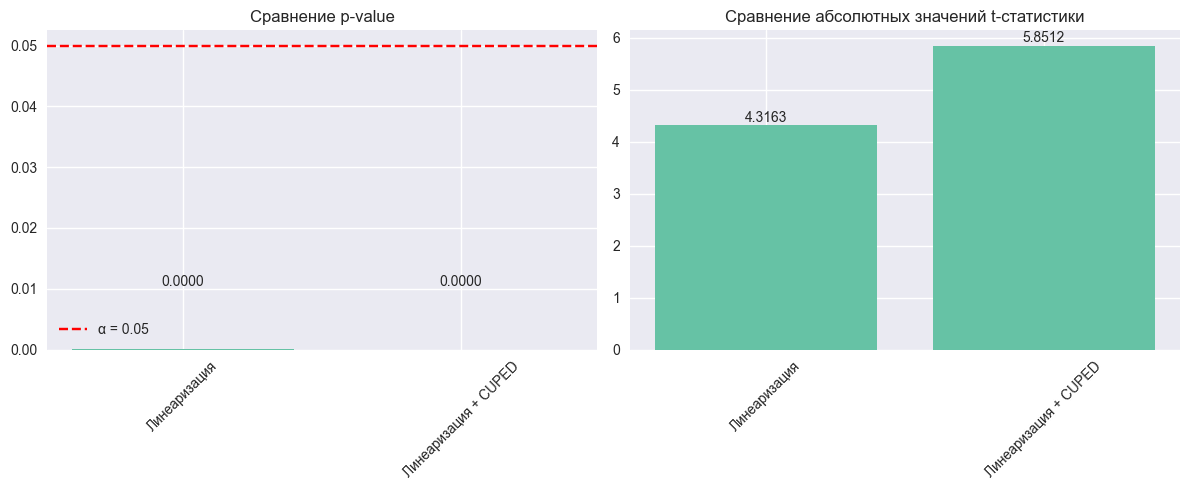

Значения для графика сонаправленности:
                   Метрика  Значение
0      Абсолютная разность  1.830525
1  Относительное изменение  0.018266


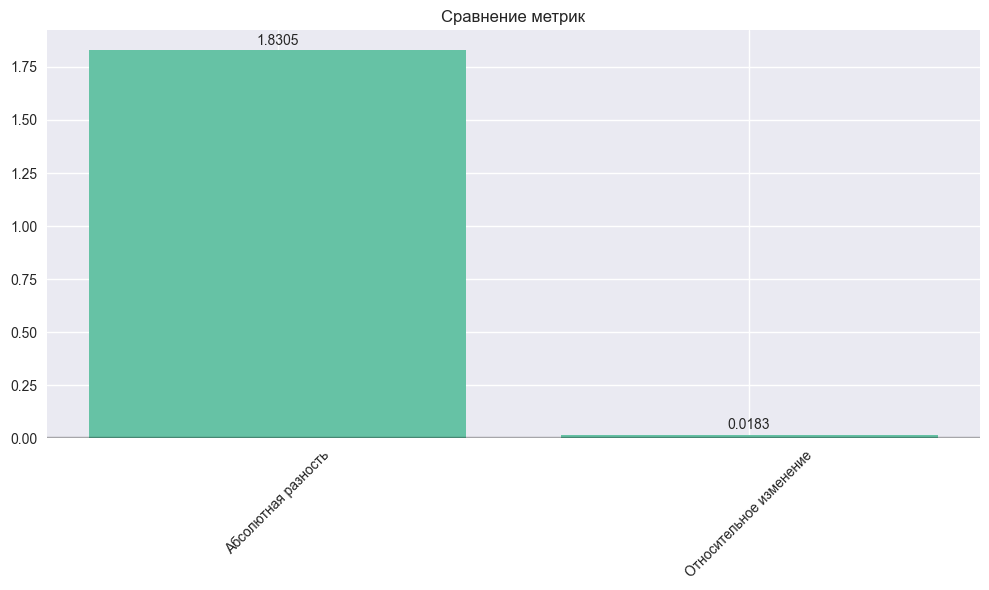

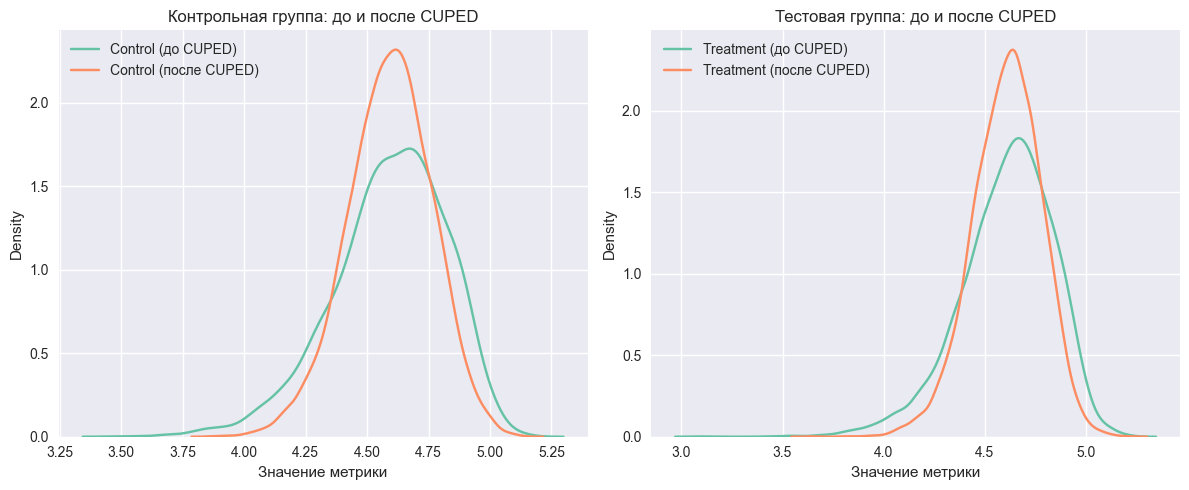

In [28]:
# Создаем DataFrame для удобства визуализации
results_df = pd.DataFrame({
    'Метод': ['Линеаризация', 'Линеаризация + CUPED'],
    'p-value': [p_value, p_value_cuped],
    't-статистика': [t_stat, t_stat_cuped]
})

# Проверяем, что все значения валидны
print("Проверка значений для визуализации:")
print(results_df)

# Заменяем NaN значения на 0 для визуализации
results_df = results_df.fillna(0)

# Визуализация результатов
plt.figure(figsize=(12, 5))

# График p-value
plt.subplot(1, 2, 1)
methods = results_df['Метод'].tolist()
p_values = results_df['p-value'].tolist()

# Проверяем, есть ли ненулевые значения
if max(p_values) > 0:
    bars = plt.bar(methods, p_values)
    plt.axhline(0.05, color='r', linestyle='--', label='α = 0.05')
    plt.title('Сравнение p-value')
    plt.xticks(rotation=45)
    
    # Добавляем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Все значения p-value равны 0 или NaN', 
             ha='center', va='center', fontsize=12)
    plt.title('Сравнение p-value')
    plt.xticks([])
    plt.yticks([])

# График t-статистики
plt.subplot(1, 2, 2)
t_stats = np.abs(results_df['t-статистика'].tolist())

# Проверяем, есть ли ненулевые значения
if max(t_stats) > 0:
    bars = plt.bar(methods, t_stats)
    plt.title('Сравнение абсолютных значений t-статистики')
    plt.xticks(rotation=45)
    
    # Добавляем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'Все значения t-статистики равны 0 или NaN', 
             ha='center', va='center', fontsize=12)
    plt.title('Сравнение абсолютных значений t-статистики')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

# Дополнительно: визуализация сонаправленности
plt.figure(figsize=(10, 6))

# Рассчитываем средние значения для каждой группы
control_mean = control_group.mean()
treatment_mean = treatment_group.mean()

# Рассчитываем разности и отношения
diff_original = treatment_mean - control_mean
ratio = treatment_mean / control_mean - 1  # Относительное изменение (в процентах)

# Создаем DataFrame для визуализации
diff_df = pd.DataFrame({
    'Метрика': ['Абсолютная разность', 'Относительное изменение'],
    'Значение': [diff_original, ratio]
})

print("Значения для графика сонаправленности:")
print(diff_df)

# Визуализация
plt.bar(diff_df['Метрика'], diff_df['Значение'])
plt.title('Сравнение метрик')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='-', alpha=0.3)

# Добавляем текстовые метки со значениями
for i, value in enumerate(diff_df['Значение']):
    plt.text(i, value + (0.01 if value >= 0 else -0.01),
             f'{value:.4f}', ha='center', va='bottom' if value >= 0 else 'top')

plt.tight_layout()
plt.show()

# Дополнительно: визуализация распределений после CUPED
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=control_lin, label='Control (до CUPED)')
sns.kdeplot(data=control_cuped, label='Control (после CUPED)')
plt.title('Контрольная группа: до и после CUPED')
plt.xlabel('Значение метрики')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=treatment_lin, label='Treatment (до CUPED)')
sns.kdeplot(data=treatment_cuped, label='Treatment (после CUPED)')
plt.title('Тестовая группа: до и после CUPED')
plt.xlabel('Значение метрики')
plt.legend()

plt.tight_layout()
plt.show()